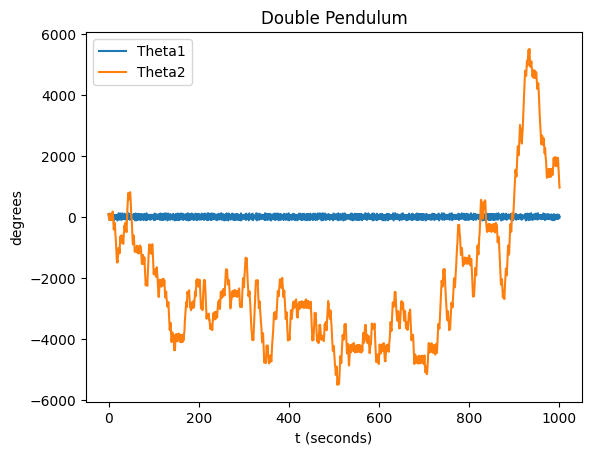

Epoch [1/100], Loss: 0.000169
Epoch [2/100], Loss: 0.000007
Epoch [3/100], Loss: 0.000005
Epoch [4/100], Loss: 0.000004
Epoch [5/100], Loss: 0.000003
Epoch [6/100], Loss: 0.000003
Epoch [7/100], Loss: 0.000002
Epoch [8/100], Loss: 0.000002
Epoch [9/100], Loss: 0.000002
Epoch [10/100], Loss: 0.000002
Epoch [11/100], Loss: 0.000002
Epoch [12/100], Loss: 0.000001
Epoch [13/100], Loss: 0.000001
Epoch [14/100], Loss: 0.000001
Epoch [15/100], Loss: 0.000001
Epoch [16/100], Loss: 0.000001
Epoch [17/100], Loss: 0.000001
Epoch [18/100], Loss: 0.000001
Epoch [19/100], Loss: 0.000001
Epoch [20/100], Loss: 0.000001
Epoch [21/100], Loss: 0.000001
Epoch [22/100], Loss: 0.000001
Epoch [23/100], Loss: 0.000001
Epoch [24/100], Loss: 0.000001
Epoch [25/100], Loss: 0.000001
Epoch [26/100], Loss: 0.000001
Epoch [27/100], Loss: 0.000001
Epoch [28/100], Loss: 0.000001
Epoch [29/100], Loss: 0.000001
Epoch [30/100], Loss: 0.000001
Epoch [31/100], Loss: 0.000001
Epoch [32/100], Loss: 0.000001
Epoch [33/100], L

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from torch.utils.data import TensorDataset, DataLoader

#preprocessing
g = 9.81
L1 = 1
L2 = 1
m1 = 1.0
m2 = 1.0

def f(r, t, L1, L2):
    theta1 = r[0]
    omega1 = r[1]
    theta2 = r[2]
    omega2 = r[3]

    ftheta1 = omega1
    fomega1 = (-g * (2 * m1 + m2) * sin(theta1) - m2 * g * sin(theta1 - 2 * theta2)
               - 2 * sin(theta1 - theta2) * m2 * (omega2**2 * L2 + omega1**2 * L1 * cos(theta1 - theta2))) / \
              (L1 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    ftheta2 = omega2
    fomega2 = (2 * sin(theta1 - theta2) * (omega1**2 * L1 * (m1 + m2) + g * (m1 + m2) * cos(theta1)
                                           + omega2**2 * L2 * m2 * cos(theta1 - theta2))) / \
              (L2 * (2 * m1 + m2 - m2 * cos(2 * theta1 - 2 * theta2)))

    return np.array([ftheta1, fomega1, ftheta2, fomega2], float)

a = 0.0
b = 1000
N = 1000000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)
theta2_points = np.zeros_like(tpoints)

q = np.array([pi / 2, 0, pi / 2, 0], float)

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / pi
    theta2_points[i] = q[2] * 180 / pi

    k1 = h * f(q, t, L1, L2)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h, L1, L2)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h, L1, L2)
    k4 = h * f(q + k3, t + h, L1, L2)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.title("Double Pendulum")
plt.xlabel("t (seconds)")
plt.ylabel("degrees")
plt.legend()
plt.show()

data = np.stack((theta1_points, theta2_points), axis=1)
np.save('pendulum_data.npy', data)

data = np.load('pendulum_data.npy')

scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 50

X, y = create_sequences(data_normalized, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
#preprocessing ends

#model
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim * SEQ_LENGTH, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        seq_length = x.size(1)
        input_dim = x.size(2)
        x = x.view(batch_size, seq_length * input_dim)  # Flatten along batch size and sequence length dimension
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_dim = 2 #input features
hidden_dim = 64 #number of hidden layers
output_dim = 2 #outputs features

#initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedforwardNN(input_dim, hidden_dim, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#train
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)  # Accumulate the total loss for the epoch

    #average
    avg_loss = total_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

#evaluate
model.eval()
predictions = []
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        predictions.append(outputs.cpu().numpy())
        nn.init.uniform_(targets, -1, 1)

predictions = np.concatenate(predictions, axis=0)
y_test = y_test.cpu().numpy()

#rmse
rmse = np.sqrt(np.mean((predictions - y_test)**2))
print(f'Test RMSE: {rmse:.6f}')

#r^2
r2 = r2_score(y_test, predictions)
print(f'Test R^2 Score: {r2:.6f}')

#this code has given a Test RMSE: 0.000186 and Test R^2 Score: 1.000000